# Lesson 15 - Image classification with Deep Learning
> An introduction to Deep Learning and its applications in computer vision.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lewtun/dslectures/blob/master/notebooks/lesson15_cv-deep.ipynb) [![slides](https://img.shields.io/static/v1?label=slides&message=lesson13_nlp-deep.pdf&color=blue&logo=Google-drive)](https://drive.google.com/open?id=REPLACE_THIS_WITH_ID)


> Note: Make sure you are connected to a GPU machine when running the Colab notebook by clicking on `Runtime -> Change runtime type` and set hardware type to GPU.

## Learning objectives
In this lecture we will use the image dataset that we in the last lecture to build an image classifier. We will again use *transfer learning* to build a accurate image classifier with deep learning in a few minutes.

You should learn how to load the dataset and build an image classifier with the *fastai* library.

## References
This lesson prepares for lesson 15 where we will create an image classifier. This content will be similar to the first lesson of the fastai course. We recommend watching the the lesson recording.
* Practical Deep Learning for Coders - Lesson 1: Image classification by fastai [[video](https://youtu.be/XfoYk_Z5AkI)]

## Homework
Use this notebook as a template to create an image classifier with your own dataset.

## Goal

In this notebook we want to create an image classifier. Images occur are very common in many areas. Imagine you would have an image of the car available in the Kaggle competition. Such an image could contain a lot of information useful for determining . Another example is a automated production line where you need to check that the parts produced correctly and there no defects.

<div style="text-align: center">
<img src='images/is-this-a-meme.jpg' width='400'>
</div>

## Transfer learning for image classification
We will again use the `fastai` library to build an image classifier with deep learning. The procedure will look very familiar, except that we don't need to fine-tune the classifier. The model we will use was pretrained on the ImageNet dataset, which contains over 14 million images and over 1'000 classes. Training a model on this dataset takes a lot of time. Fortunately, we can re-use the freely available models trained on this dataset to then train new classifiers on other datasets. Because the dataset is so diverse the model learns a lot about the general structure of images.

<div style="text-align: center">
<img src='images/imagenet.jpeg' width='400'><p style="text-align: center;"> <b>Reference:</b> http://karpathy.github.io/2014/09/02/what-i-learned-from-competing-against-a-convnet-on-imagenet/ </p>
</div>

The code to train an image classifier should look familiar, since we used a very similar approach in Lesson 13 to trian a language model for text classification. The main difference will be the `learner` which will be a `cnn_learner`.

## Install fastai library
First we need to install the fastai library since we need some of its helper functions to download images and then also visualise the downloaded images.

> Note: This step might take a few minutes.

In [ ]:
# !pip install fastai --no-cache-dir -qq

## Import

Then we can import the `ImageDownloader` and the fastai helper functions.

In [ ]:
# uncomment if running locally or on Google Colab
# !pip install --upgrade dslectures

In [ ]:
from fastai.vision import *

## Load dataset
First we need to load the dataset.

We apply a few tricks when we load the data:
1. A trick often used in image classification is data augmentation. This means one creates more data by manipulating existing data. For images this means that the images can be rotated, flipped cropped etc. This generally improves the performance of the classifier and is setup with the `get_transforms` function.
2. We split the data 80/20 into train and validation data.
3. We crop the images to a size of 224 pixels.

In [ ]:
tfms = get_transforms()
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, valid_pct=0.2, size=224)

In [ ]:
data.show_batch(rows=3, figsize=(8, 8)) 

In [ ]:
print(data.classes) 

## Create learner

Training a model involves the same steps we encountered in the `ULMFiT` lecture:

1. Load a pretrained model (e.g. resnet34, resnet50, etc)
2. Find the optimal learning rate
3. Fit the head of the network
4. Unfreeze all layers and fine-tune
5. Evaluate the results

Let's got through each step in turn.

We load a ResNet34 model, which is a convolutional neural network with 34 layers. There are also larger networks with up to 150 layers but this model usually takes the least effort to train a get good results. Furthermore, we also specifiy that we want to monitor the accuracy during training.

### Load pretrained model

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

### Find the optimal learning rate
In this step, the goal is to find the best learning rate that a) avoids overshooting during stochastic gradient descent, and b) converges as a fast as possible. We are looking for the spot in the graph where the line has the steepest slope. This means that the model is improving the most with that learning rate.

In [ ]:
learn.lr_find()
learn.recorder.plot()

### Train the head of the network
Resnet34 was trained on ImageNet which has 1,000 classes instead of our measly few. Thus we first need to train the head of the network to adapt it to our use case:

In [ ]:
learn.fit_one_cycle(cyc_len=3, max_lr=1e-2)

We save the progress, so we don't have to retrain the model from scratch if we want to go back a step.

In [ ]:
learn.save('tmp_fit-head')

In [ ]:
learn.load('tmp_fit-head');

### Train all layers
Now that we've tuned the head of the network to our dataset, the next step is to unfreeze all the layers, and see if we can generate a more accurate model. The procedure is the same as in the previous step: 
1. Find the best learning rate.
2. Train the network with this learning rate.

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(2, 1e-6)

In [ ]:
learn.save('tmp_fit-all')

In [ ]:
learn.load('tmp_fit-all');

With the unfreezing and repeated fine-tuning we gained a slight boost and achieved 92.8% classification accuracy!

### Evaluate the results
Let's see which classes our classifier is having the most identifying correctly:

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

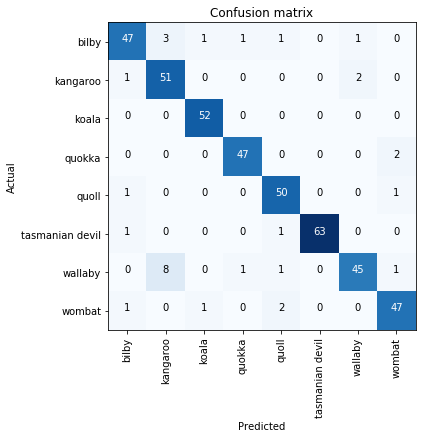

In [ ]:
interp.plot_confusion_matrix(figsize=(6,6))

Unsuprisingly, distinguishing kangaroos from wallabies is giving it the most trouble. Otherwise, the confusion matrix looks pretty good. Next, let's look at the worst predictions:

In [ ]:
interp.plot_top_losses(16, figsize=(20,10))

OK we clearly have some quirks in the dataset - let's see if we can clean it up and get a better accuracy.

## Data cleaning
fast.ai also comes with a nifty `ImageCleaner` that we can use to either remove images or correct the labels:

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn)

In [ ]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

The results are stored in a csv file named `cleaned.csv`.

In [ ]:
path.ls()

[PosixPath('/storage/fri-ml/image_downloader/cleaned.csv'),
 PosixPath('/storage/fri-ml/image_downloader/wallaby'),
 PosixPath('/storage/fri-ml/image_downloader/quokka'),
 PosixPath('/storage/fri-ml/image_downloader/koala'),
 PosixPath('/storage/fri-ml/image_downloader/wombat'),
 PosixPath('/storage/fri-ml/image_downloader/bilby'),
 PosixPath('/storage/fri-ml/image_downloader/tasmanian devil'),
 PosixPath('/storage/fri-ml/image_downloader/kangaroo'),
 PosixPath('/storage/fri-ml/image_downloader/quoll'),
 PosixPath('/storage/fri-ml/image_downloader/models'),
 PosixPath('/storage/fri-ml/image_downloader/.ipynb_checkpoints')]

We can load the cleaned dataset and repeat the training steps above with a new classifier:

In [ ]:
data = ImageDataBunch.from_csv(path, csv_labels='cleaned.csv', ds_tfms=tfms, valid_pct=0.2, size=224)

In [ ]:
data.show_batch(rows=3, figsize=(8, 8))

### Load a pretrained model

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

### Fit the head

In [ ]:
learn.fit_one_cycle(3, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.990181,0.398701,0.857678
2,0.615025,0.369807,0.883895
3,0.451079,0.263094,0.902622


In [ ]:
learn.save('tmp_fit-head-clean')

In [ ]:
learn.load('tmp_fit-head-clean');

### Unfreeze all layers

In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


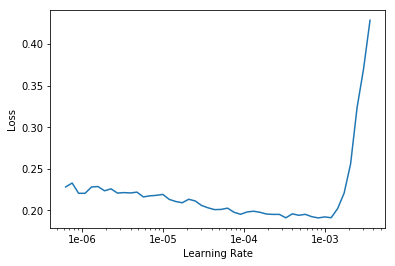

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(3, 1e-4)

epoch,train_loss,valid_loss,accuracy
1,0.212600,0.248231,0.917603
2,0.165235,0.214420,0.928839
3,0.142316,0.213099,0.932584


In [ ]:
learn.save('tmp_fit-all-clean')

In [ ]:
learn.load('tmp_fit-all-clean');

Evidently, the cleaning has helped give us yet another small boost and achieve **93.3% accuracy**! Also the confusion matrix looks quite acceptable now:

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))

We can also look at the classes that were most frequently confused:

In [ ]:
interp.most_confused()

[('kangaroo', 'wallaby', 8),
 ('quokka', 'wallaby', 3),
 ('wallaby', 'kangaroo', 2)]

Looking at the top losses we see again that there are some pictures in the wrong class or totally unrelated. In another cleaning phase we could further improve the performence by cleaning the dataset.

In [ ]:
interp.plot_top_losses(16, figsize=(20,10))

In addition to the top losses on can also look at the minimum losses or in other words the images that were best classified:

In [ ]:
interp.plot_top_losses(16, figsize=(20,10), largest=False)